In [1]:
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

import seaborn as sns
from pylab import rcParams
from matplotlib import rc

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, concatenate, LSTM, Input, Bidirectional, Input, Conv1D, MaxPooling1D, Add, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import callbacks
from keras.utils.vis_utils import plot_model

import pmdarima
from pmdarima.metrics import smape

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf


In [2]:
df = pd.read_excel('2021_Interface+RESLocal_1.xls', index_col=[0], parse_dates=[0])

portugal_holidays_csv = pd.read_csv('Holidays.csv')

In [3]:
SAVE_DIR = 'images'

# EDA

In [4]:
df.head()

,Interface [MW],Geração Local [MW]
DATA,,
2021-01-01 00:00:00,19.753853,0.0
2021-01-01 01:00:00,18.472114,0.0
2021-01-01 02:00:00,17.617622,0.0
2021-01-01 03:00:00,16.599771,0.0
2021-01-01 04:00:00,16.298185,0.0


In [5]:
portugal_holidays_csv.head()

,date
0,1970-01-01
1,1970-03-27
2,1970-03-29
3,1970-05-28
4,1970-10-05


In [6]:
pt_2021_holidays = portugal_holidays_csv[pd.to_datetime(portugal_holidays_csv['date']).dt.year==2021]
pt_2021_holidays.head()

,date
647,2021-01-01
648,2021-04-02
649,2021-04-04
650,2021-06-03
651,2021-10-05


In [7]:
pt_2021_holidays.tail()

,date
655,2021-05-01
656,2021-06-10
657,2021-08-15
658,2021-12-08
659,2021-12-25


In [8]:
df.shape

(8712, 2)

In [9]:
# Nans Count
df.isna().sum()

Interface [MW]        0
Geração Local [MW]    0
dtype: int64

In [10]:
# Duplicated Values (based on Date)
df[df.index.isin(df.index[df.index.duplicated()])]

,Interface [MW],Geração Local [MW]
DATA,,
2021-10-31 01:00:00,15.996599,0.0
2021-10-31 01:00:00,15.870939,0.0


In [11]:
# Remove duplicates
df = df[~df.index.duplicated(keep='first')]

In [12]:
df.shape

(8711, 2)

In [13]:
def create_features(df):
    df['Date'] = df.index
    df.reset_index()
    df['Date_Parsed'] = df['Date'].dt.strftime('%Y-%m-%d')
    df['Hour'] = df['Date'].dt.hour
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Quarter'] = df['Date'].dt.quarter
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['DayOfMonth'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.weekofyear
    df['DayOfYearFloat'] = df['DayOfYear'] + df['Hour'] / 24
#     df.drop('Date', axis=1, inplace=True)
    return df

df = create_features(df)
df.head()

,Interface [MW],Geração Local [MW],Date,Date_Parsed,Hour,DayOfWeek,Quarter,Month,Year,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat
DATA,,,,,,,,,,,,,
2021-01-01 00:00:00,19.753853,0.0,2021-01-01 00:00:00,2021-01-01,0,4,1,1,2021,1,1,53,1.000000
2021-01-01 01:00:00,18.472114,0.0,2021-01-01 01:00:00,2021-01-01,1,4,1,1,2021,1,1,53,1.041667
2021-01-01 02:00:00,17.617622,0.0,2021-01-01 02:00:00,2021-01-01,2,4,1,1,2021,1,1,53,1.083333
2021-01-01 03:00:00,16.599771,0.0,2021-01-01 03:00:00,2021-01-01,3,4,1,1,2021,1,1,53,1.125000
2021-01-01 04:00:00,16.298185,0.0,2021-01-01 04:00:00,2021-01-01,4,4,1,1,2021,1,1,53,1.166667


In [14]:
# Rename columns

df.rename(columns = {'Interface [MW]':'Interface', 'Geração Local [MW]':'Local Generation'}, inplace = True)

In [15]:
df.columns

Index(['Interface', 'Local Generation', 'Date', 'Date_Parsed', 'Hour',
       'DayOfWeek', 'Quarter', 'Month', 'Year', 'DayOfYear', 'DayOfMonth',
       'WeekOfYear', 'DayOfYearFloat'],
      dtype='object')

In [16]:
np.unique(df['Year'])

array([2021], dtype=int64)

In [17]:
days_of_week_by_month_2021 = df.groupby('Month')['DayOfYear'].agg(['min', 'max', 'count', 'nunique'])
days_of_week_by_month_2021

# It seems that there are values missing in June (One day is missing)
# Missing hour in March (Count!=744 for 31 days as seen below in the next cell)

,min,max,count,nunique
Month,,,,
1,1,31,744,31
2,32,59,672,28
3,60,90,743,31
4,91,120,720,30
5,121,151,744,31
6,152,180,696,29
7,182,212,744,31
8,213,243,744,31
9,244,273,720,30


## Let's find out what's missing in the dataset

In [18]:
df_days = days_of_week_by_month_2021['nunique']

for i in range(len(df_days)):
    print('Expected hours: Month {} -> {}'.format(i+1, df_days[i+1]*24))
    
# March has less an hour than expected

Expected hours: Month 1 -> 744
Expected hours: Month 2 -> 672
Expected hours: Month 3 -> 744
Expected hours: Month 4 -> 720
Expected hours: Month 5 -> 744
Expected hours: Month 6 -> 696
Expected hours: Month 7 -> 744
Expected hours: Month 8 -> 744
Expected hours: Month 9 -> 720
Expected hours: Month 10 -> 744
Expected hours: Month 11 -> 720
Expected hours: Month 12 -> 720


In [19]:
march_hours= df[df['Month']==3].groupby('DayOfMonth')['Hour'].agg(['count', 'nunique'])
march_hours

# Day 28 has less one hour than expected

,count,nunique
DayOfMonth,,
1,24,24
2,24,24
3,24,24
4,24,24
5,24,24
6,24,24
7,24,24
8,24,24
9,24,24


In [20]:
np.unique(df[(df['Month']==3) & (df['DayOfMonth']==28)]['Hour'])

# First hour of March is missing

array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23], dtype=int64)

In [21]:
np.unique(df[df['Month']==6]['Date_Parsed'])

# 30th of June is missing

array(['2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04',
       '2021-06-05', '2021-06-06', '2021-06-07', '2021-06-08',
       '2021-06-09', '2021-06-10', '2021-06-11', '2021-06-12',
       '2021-06-13', '2021-06-14', '2021-06-15', '2021-06-16',
       '2021-06-17', '2021-06-18', '2021-06-19', '2021-06-20',
       '2021-06-21', '2021-06-22', '2021-06-23', '2021-06-24',
       '2021-06-25', '2021-06-26', '2021-06-27', '2021-06-28',
       '2021-06-29'], dtype=object)

In [22]:
np.unique(df[df['Month']==12]['Date_Parsed'])

# 31st of December is missing (Probably not that important)

array(['2021-12-01', '2021-12-02', '2021-12-03', '2021-12-04',
       '2021-12-05', '2021-12-06', '2021-12-07', '2021-12-08',
       '2021-12-09', '2021-12-10', '2021-12-11', '2021-12-12',
       '2021-12-13', '2021-12-14', '2021-12-15', '2021-12-16',
       '2021-12-17', '2021-12-18', '2021-12-19', '2021-12-20',
       '2021-12-21', '2021-12-22', '2021-12-23', '2021-12-24',
       '2021-12-25', '2021-12-26', '2021-12-27', '2021-12-28',
       '2021-12-29', '2021-12-30'], dtype=object)

## Deal with missing data

In [23]:
new_df = df.copy()
new_df = new_df.asfreq('H')
new_df = create_features(new_df)
new_df[(new_df['Month']==3)&(new_df['DayOfMonth']==28)].head()

# Create hours missing in the dataset

,Interface,Local Generation,Date,Date_Parsed,Hour,DayOfWeek,Quarter,Month,Year,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat
DATA,,,,,,,,,,,,,
2021-03-28 00:00:00,18.283623,0.0,2021-03-28 00:00:00,2021-03-28,0,6,1,3,2021,87,28,12,87.000000
2021-03-28 01:00:00,NaN,NaN,2021-03-28 01:00:00,2021-03-28,1,6,1,3,2021,87,28,12,87.041667
2021-03-28 02:00:00,17.693018,0.0,2021-03-28 02:00:00,2021-03-28,2,6,1,3,2021,87,28,12,87.083333
2021-03-28 03:00:00,17.240640,0.0,2021-03-28 03:00:00,2021-03-28,3,6,1,3,2021,87,28,12,87.125000
2021-03-28 04:00:00,17.089847,0.0,2021-03-28 04:00:00,2021-03-28,4,6,1,3,2021,87,28,12,87.166667


In [24]:
new_df['Interface'] = new_df['Interface'].interpolate(method='polynomial', order=2)
new_df['Local Generation'] = new_df['Local Generation'].interpolate(method='polynomial', order=2)
new_df[(new_df['Month']==3)&(new_df['DayOfMonth']==28)].head()

# Polynomial Interpolation (due to the data convex behaviour) in the missing data

,Interface,Local Generation,Date,Date_Parsed,Hour,DayOfWeek,Quarter,Month,Year,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat
DATA,,,,,,,,,,,,,
2021-03-28 00:00:00,18.283623,0.000000,2021-03-28 00:00:00,2021-03-28,0,6,1,3,2021,87,28,12,87.000000
2021-03-28 01:00:00,18.002523,-0.000027,2021-03-28 01:00:00,2021-03-28,1,6,1,3,2021,87,28,12,87.041667
2021-03-28 02:00:00,17.693018,0.000000,2021-03-28 02:00:00,2021-03-28,2,6,1,3,2021,87,28,12,87.083333
2021-03-28 03:00:00,17.240640,0.000000,2021-03-28 03:00:00,2021-03-28,3,6,1,3,2021,87,28,12,87.125000
2021-03-28 04:00:00,17.089847,0.000000,2021-03-28 04:00:00,2021-03-28,4,6,1,3,2021,87,28,12,87.166667


In [25]:
mask = new_df['DayOfWeek'] <= 4

In [26]:
new_df.loc[mask, 'is_workday'] = 1
new_df.loc[~mask, 'is_workday'] = 0

In [27]:
new_df.drop('Date', axis=1, inplace=True)

In [28]:
new_df.rename(columns = {'Date_Parsed':'date'}, inplace = True)

In [29]:
new_df.shape

(8736, 13)

In [30]:
mask = new_df.assign(result=new_df['date'].isin(pt_2021_holidays['date']))['result']

In [31]:
new_df.loc[mask, 'is_workday'] = 0

# assign 0 if holidays and weekends, and 1 if weekday in the 'is_workday' column

In [32]:
new_df['season_of_year'] = pd.to_datetime(new_df['date']).dt.month%12 // 3 + 1

# assign the season of year column
# starting in the beggining of each month ex: Spring starts at 21st March - We consider it to start at 1st of March
# this analysis was based in the data behaviour seen in the boxplot analysis

In [33]:
new_df[new_df['date']=='2021-03-01'].head()

,Interface,Local Generation,date,Hour,DayOfWeek,Quarter,Month,Year,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat,is_workday,season_of_year
DATA,,,,,,,,,,,,,,
2021-03-01 00:00:00,16.964186,0.0,2021-03-01,0,0,1,3,2021,60,1,9,60.000000,1.0,2
2021-03-01 01:00:00,16.185090,0.0,2021-03-01,1,0,1,3,2021,60,1,9,60.041667,1.0,2
2021-03-01 02:00:00,15.456259,0.0,2021-03-01,2,0,1,3,2021,60,1,9,60.083333,1.0,2
2021-03-01 03:00:00,15.230070,0.0,2021-03-01,3,0,1,3,2021,60,1,9,60.125000,1.0,2
2021-03-01 04:00:00,14.953616,0.0,2021-03-01,4,0,1,3,2021,60,1,9,60.166667,1.0,2


In [34]:
new_df.drop(new_df[new_df['date'] == '2021-12-31'].index, inplace = True)
# Drop day 31st December

# Graphical Analysis

Text(0, 0.5, 'Interface')

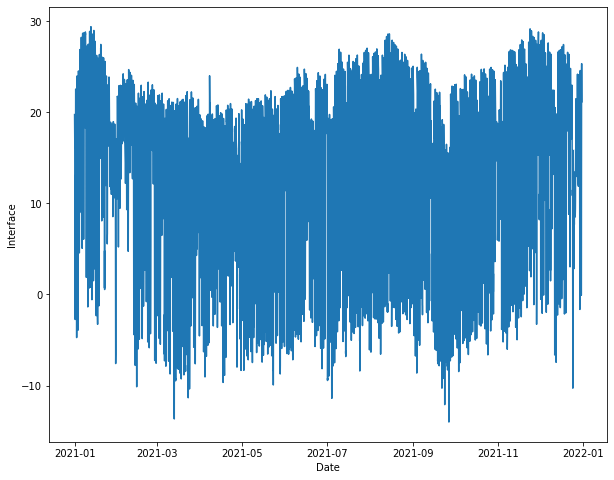

In [35]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
# Interface Data
plt.plot(new_df.index, new_df['Interface'])
plt.xlabel("Date")
plt.ylabel("Interface")

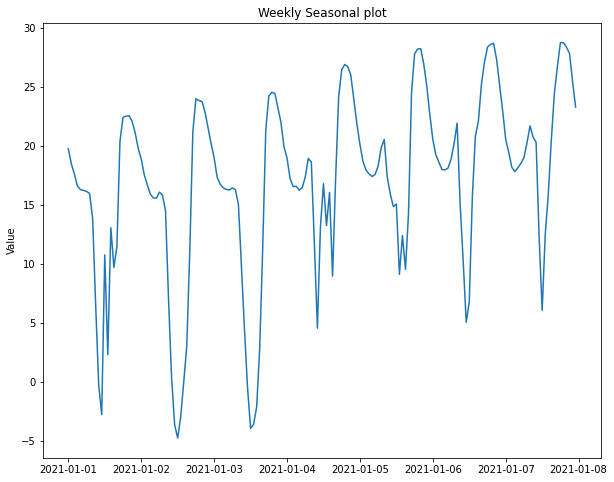

In [36]:
# First week of the year
WEEK_END_INDEX = 7*24
plt.plot(new_df.index[:WEEK_END_INDEX], new_df['Interface'][:WEEK_END_INDEX])
plt.title('Weekly Seasonal plot')
plt.ylabel('Value')
plt.show()

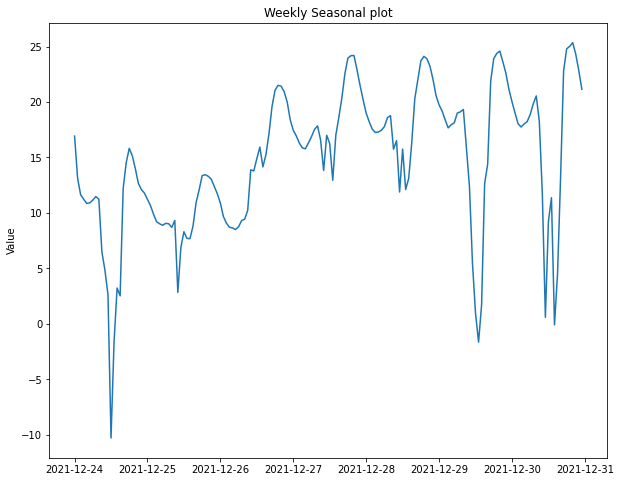

In [37]:
# Last week of the year
WEEK_END_INDEX = 7*24
plt.plot(new_df.index[-WEEK_END_INDEX:], new_df['Interface'][-WEEK_END_INDEX:])
plt.title('Weekly Seasonal plot')
plt.ylabel('Value')
plt.savefig('weekly_saz_plot.png')
plt.show()

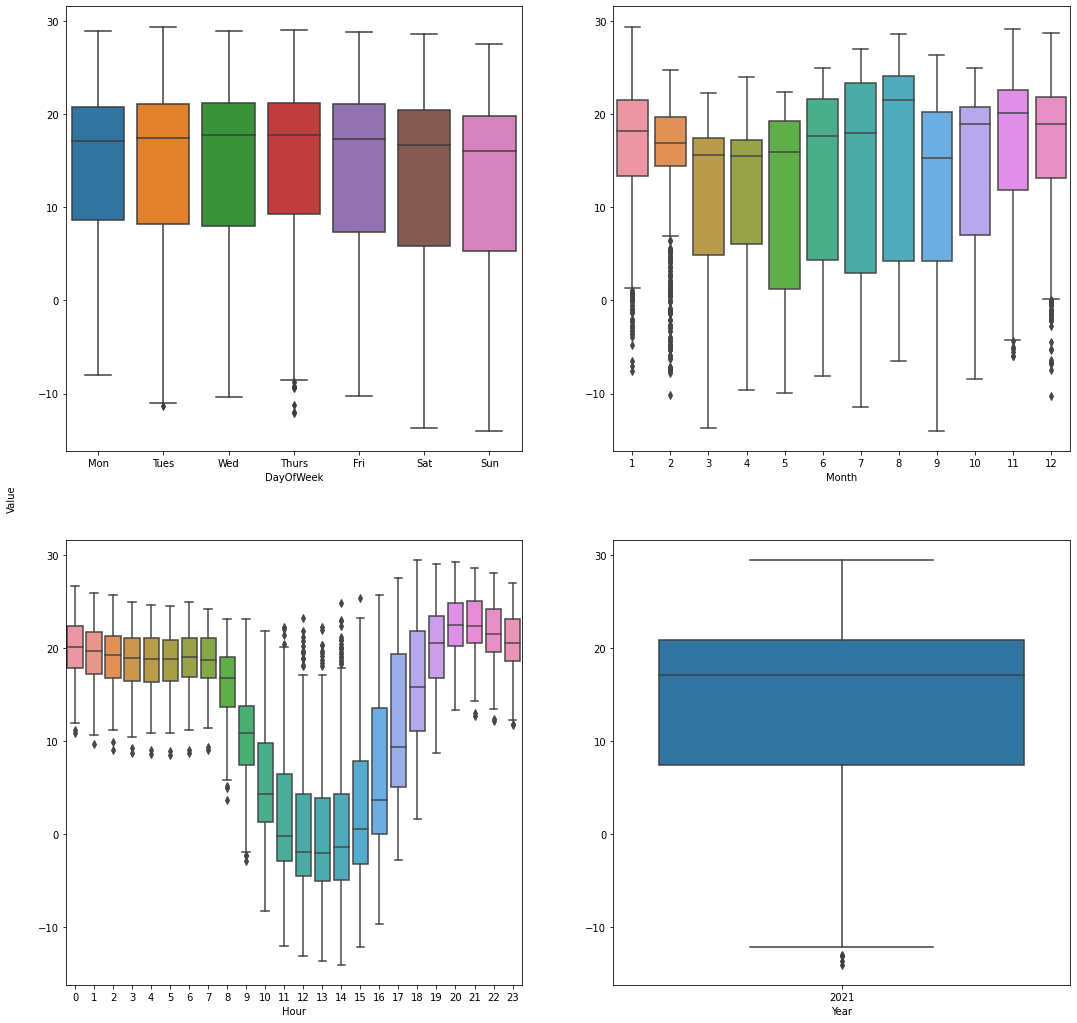

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(18,18))

# Day of Week
dow_labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
g = sns.boxplot(x=new_df.DayOfWeek, y=new_df.Interface, ax=axes[0][0])
g.set_xticklabels(dow_labels)
g.set_ylabel('')

# Month of Year
g = sns.boxplot(x=new_df.Month, y=new_df.Interface, ax=axes[0][1])
g.set_ylabel('')

# Hour of Day
g = sns.boxplot(x=new_df.Hour, y=new_df.Interface, ax=axes[1][0])
g.set_ylabel('')

# Year
g = sns.boxplot(x=new_df.Year, y=new_df.Interface, ax=axes[1][1])
g.set_ylabel('')
fig.text(0.08, 0.5, 'Value', va='center', rotation='vertical')
plt.show()

# Several Outliers in Jan, Feb and Dec (Months with more energy consumption due to the cold/smaller days)
# Major problem -> between Mar and Oct (Much of the generated energy was not used)
# 9h - 18h - Tends to generate too much energy (Energy that isn't used by the costumer - Waste/Costly hours)

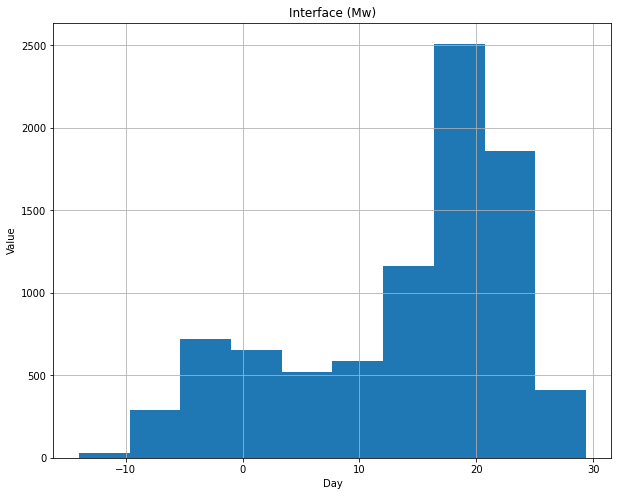

In [39]:
new_df['Interface'].hist()
plt.xlabel('Day')
plt.ylabel('Value')
plt.title('Interface (Mw)')
plt.show()

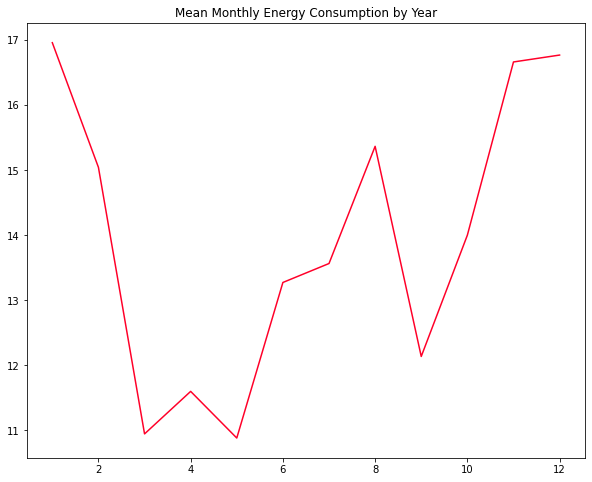

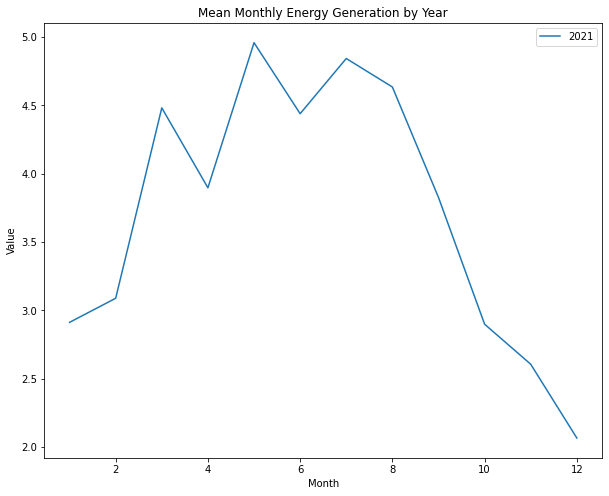

In [40]:
year_group = new_df.groupby(['Year', 'Month']).mean().reset_index()
years = new_df['Year'].unique()
NUM_COLORS = len(years)

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for i, y in enumerate(years):
    _df = year_group[year_group['Year'] == y]
    plt.title('Mean Monthly Energy Consumption by Year')
    plt.plot(_df['Month'], _df['Interface'])
    plt.show()
    plt.title('Mean Monthly Energy Generation by Year')
    plt.plot(_df['Month'], _df['Local Generation'])
    
plt.xlabel('Month')
plt.ylabel('Value')
plt.legend(new_df.Year.unique())
plt.show()

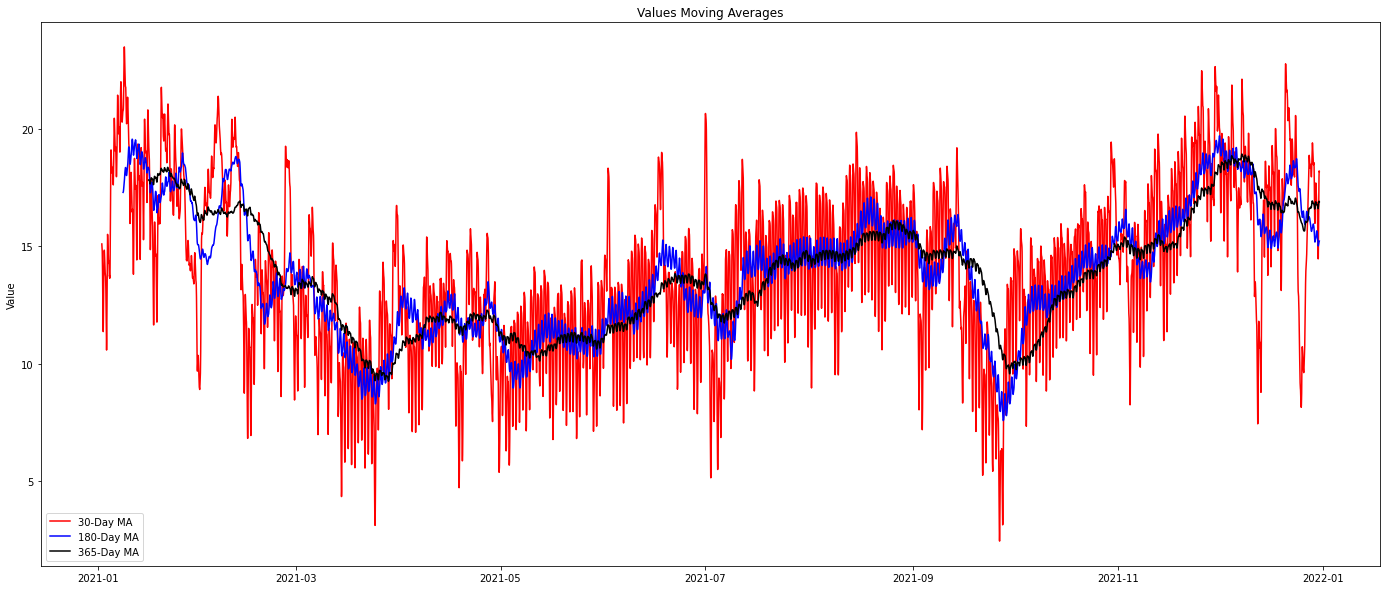

In [41]:
MONTH_PERIOD = 30
MIDYEAR_PERIOD = 182
YEAR_PERIOD = 365

month_roll = new_df['Interface'].rolling(MONTH_PERIOD).mean()
midyear_roll = new_df['Interface'].rolling(MIDYEAR_PERIOD).mean()
year_roll = new_df['Interface'].rolling(YEAR_PERIOD).mean()

fig, ax = plt.subplots(figsize=(24, 10))
plt.plot(month_roll.index, month_roll, color='red', label='30-Day MA')
plt.plot(midyear_roll.index, midyear_roll, color='blue', label='180-Day MA')
plt.plot(year_roll.index, year_roll, color='black', label='365-Day MA')
plt.title('Values Moving Averages')
plt.ylabel('Value')
plt.legend()
plt.show()

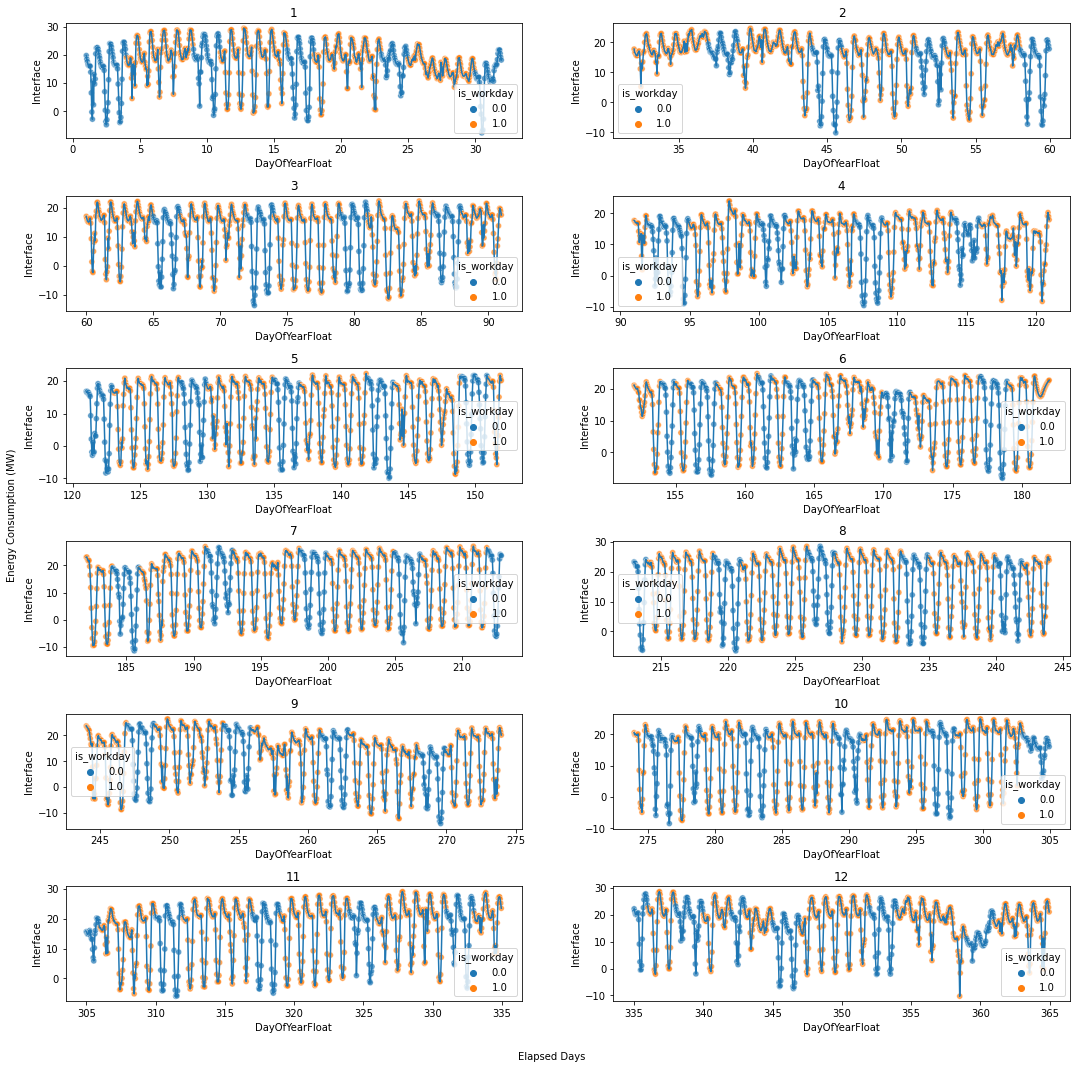

In [42]:
# Monthly Interface Energy Consumption
# Blue color - holidays and weekends
# Orange color - workdays (weekdays that are not holidays)

num_rows = 6
num_cols = 2
month_index = 0

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18,18))
months = new_df['Month'].unique()

for i in range(num_rows):
    for j in range(num_cols):
        df = new_df[new_df['Month'] == months[month_index]]
        sns.lineplot(data=df, x='DayOfYearFloat', y='Interface', ax=axes[i,j], palette="flare")
        sns.scatterplot(data=df, x='DayOfYearFloat', y='Interface', alpha=0.7, hue='is_workday', ax=axes[i,j])
        axes[i][j].set_title(str(months[month_index]))
        month_index += 1
        
fig.text(0.5, 0.08, 'Elapsed Days', ha='center')
fig.text(0.08, 0.5, 'Energy Consumption (MW)', va='center', rotation='vertical')
fig.subplots_adjust(hspace=0.5)
plt.show()

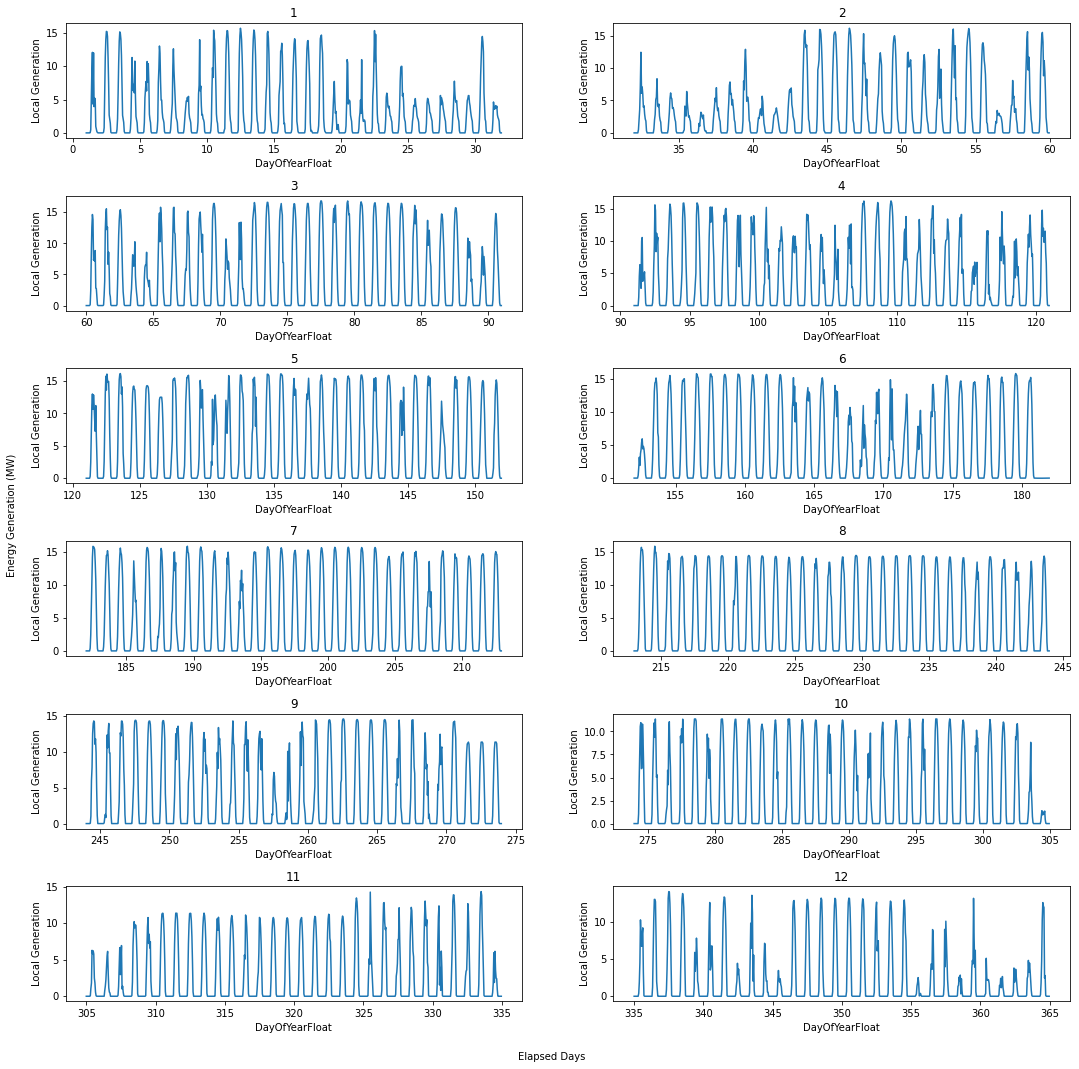

In [43]:
# Local Generation Monthly plot

num_rows = 6
num_cols = 2
month_index = 0

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18,18))
months = new_df['Month'].unique()

for i in range(num_rows):
    for j in range(num_cols):
        df = new_df[new_df['Month'] == months[month_index]]
        sns.lineplot(data=df, x='DayOfYearFloat', y='Local Generation', ax=axes[i,j], palette="flare")
#         sns.scatterplot(data=df, x='DayOfYearFloat', y='Local Generation', alpha=0.7, hue='season_of_year', ax=axes[i,j])
        axes[i][j].set_title(str(months[month_index]))
        month_index += 1
        
fig.text(0.5, 0.08, 'Elapsed Days', ha='center')
fig.text(0.08, 0.5, 'Energy Generation (MW)', va='center', rotation='vertical')
fig.subplots_adjust(hspace=0.5)
plt.show()

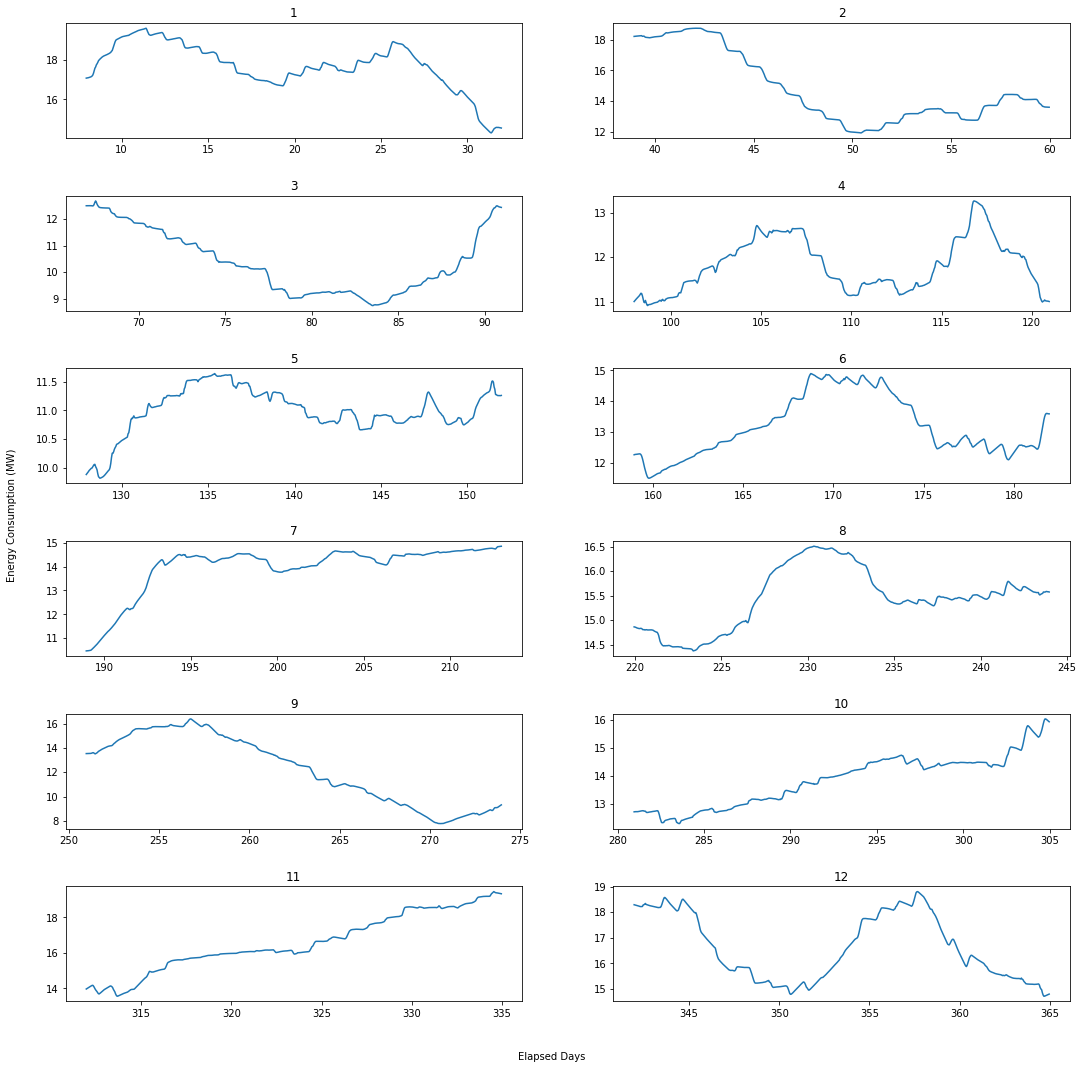

In [44]:
num_rows = 6
num_cols = 2
month_index = 0

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18,18))
months = new_df['Month'].unique()

for i in range(num_rows):
    for j in range(num_cols):
        df = new_df[new_df['Month'] == months[month_index]]
        rolling_mean = df['Interface'].rolling(window=7*24).mean()
        axes[i][j].plot(df['DayOfYearFloat'], rolling_mean.values)
        axes[i][j].set_title(str(months[month_index]))
        month_index += 1
        
fig.text(0.5, 0.08, 'Elapsed Days', ha='center')
fig.text(0.08, 0.5, 'Energy Consumption (MW)', va='center', rotation='vertical')
fig.subplots_adjust(hspace=0.5)
plt.show()

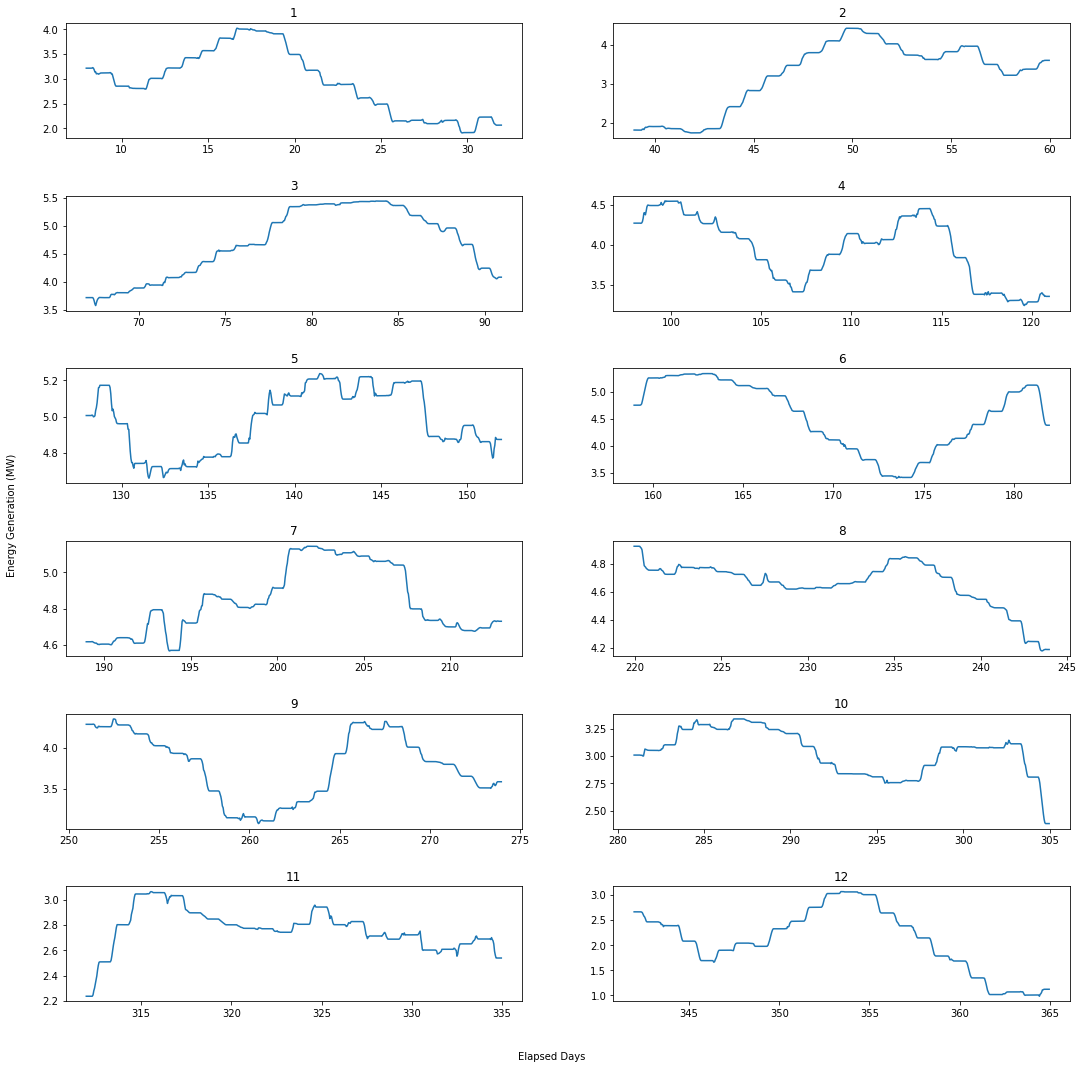

In [45]:
num_rows = 6
num_cols = 2
month_index = 0

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18,18))
months = new_df['Month'].unique()

for i in range(num_rows):
    for j in range(num_cols):
        df = new_df[new_df['Month'] == months[month_index]]
        rolling_mean = df['Local Generation'].rolling(window=7*24).mean()
        axes[i][j].plot(df['DayOfYearFloat'], rolling_mean.values)
        axes[i][j].set_title(str(months[month_index]))
        month_index += 1
        
fig.text(0.5, 0.08, 'Elapsed Days', ha='center')
fig.text(0.08, 0.5, 'Energy Generation (MW)', va='center', rotation='vertical')
fig.subplots_adjust(hspace=0.5)
plt.show()

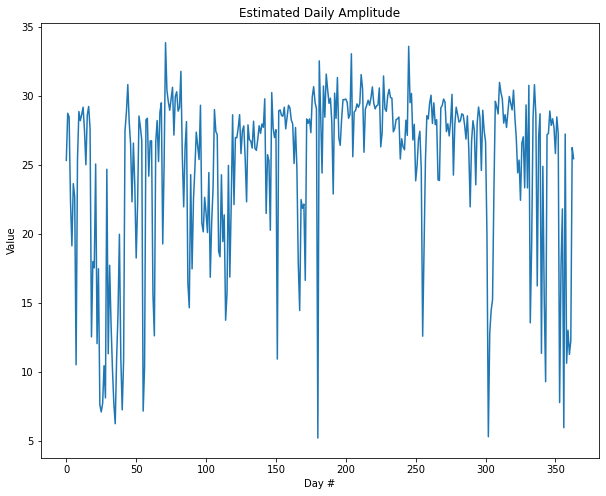

In [46]:
max_daily_vals = new_df.groupby(['Year', 'DayOfYear']).max()['Interface'].values
min_daily_vals = new_df.groupby(['Year', 'DayOfYear']).min()['Interface'].values
daily_amp = max_daily_vals - min_daily_vals
plt.plot(daily_amp)
plt.xlabel('Day #')
plt.ylabel('Value')
plt.title('Estimated Daily Amplitude')
plt.show()

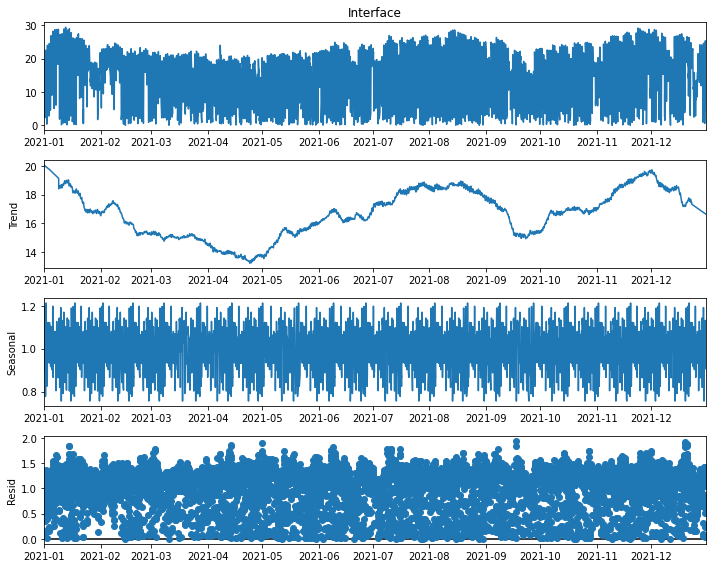

In [47]:
# Seasonal Decomposition

ANNUAL_PERIOD = 365
mult_decomp = seasonal_decompose(new_df[new_df['Interface']>0]['Interface'].dropna(), model='multiplicative', extrapolate_trend='freq', period=ANNUAL_PERIOD)
mult_decomp.plot()
plt.show()

# Is the series stationary?

In [48]:
adf_result = adfuller(new_df['Interface'], regression='nc') # No trend

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# Reject null hypothesis - Time Series has a Unit Root (Not Stationary)

ADF Statistic: -1.679897764870765
p-value: 0.08798439055353369


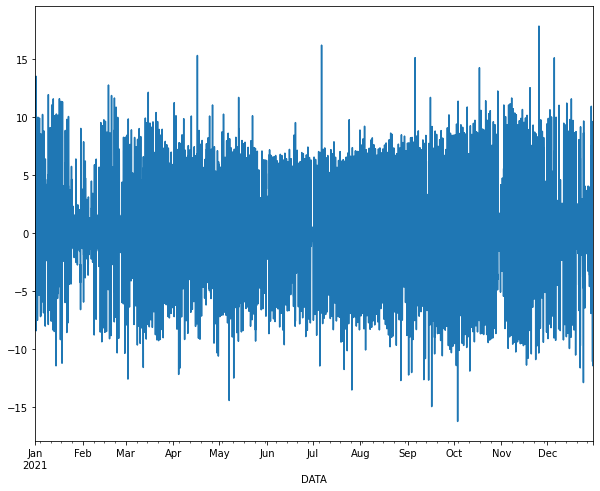

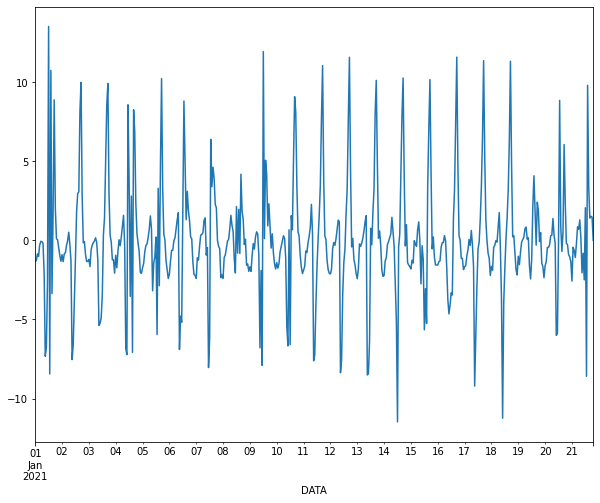

In [49]:
interface_first_difference = new_df['Interface'].diff()
interface_first_difference.plot()
plt.show()

interface_first_difference[:500].plot()
plt.show()

# We still see some seasonality

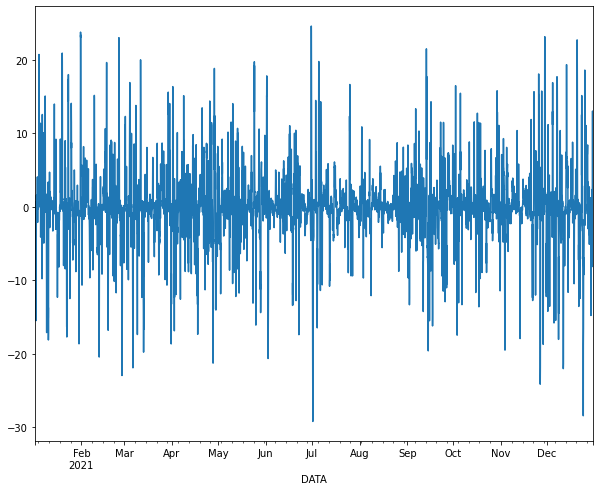

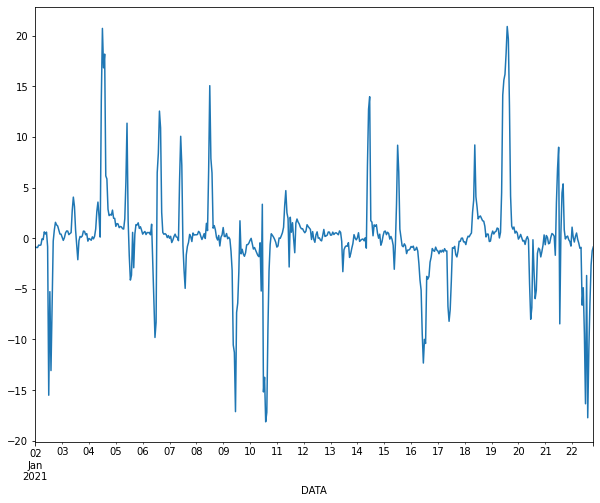

In [50]:
#  Since we are dealing with daily data our period will be 24 hours
test = new_df
test['first_difference'] = test['Interface'].diff(24)
test = test.dropna()
test['first_difference'].plot()
plt.show()

test['first_difference'][:500].plot()
plt.show()

# Hurray! Less Seasonality!

In [51]:
adf_result = adfuller(test['first_difference'], regression='nc')

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# p-val = 3.512418133295498e-29 < 0.05 - First Difference over a 24 hour period is stationary

ADF Statistic: -18.86081523178963
p-value: 3.512418133295498e-29


In [52]:
adf_result = adfuller(new_df['Local Generation'], regression='nc')

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# Local Generation is Stationary

ADF Statistic: -2.326005111452399
p-value: 0.01927698375192262


<AxesSubplot:xlabel='DATA'>

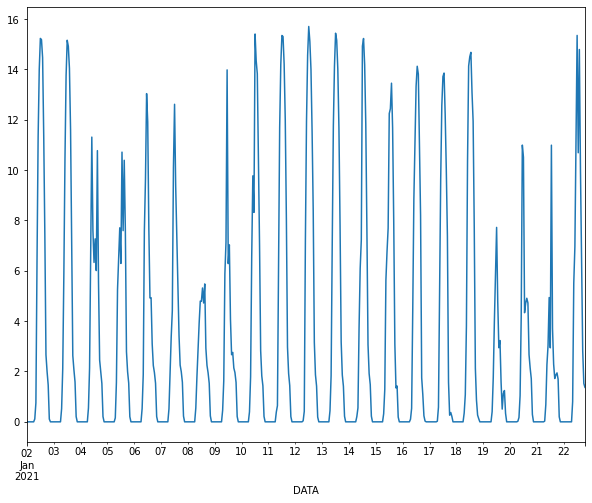

In [53]:
test['Local Generation'][:500].plot()

# Seasonality in the Local Generation time series, let's do the same thing we did with Interface to remove seasonality

<AxesSubplot:xlabel='DATA'>

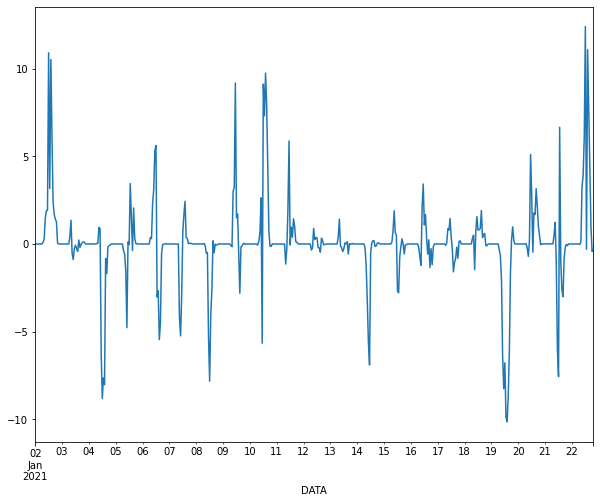

In [54]:
local_gen_first_difference = new_df['Local Generation'].diff(24).dropna()

local_gen_first_difference[:500].plot()

# Removed seasonality - Great news!

In [55]:
test['local_gen_first_difference'] = local_gen_first_difference

In [56]:
adf_result = adfuller(test['local_gen_first_difference'], regression='nc')

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# Local Generation first difference also stationary

ADF Statistic: -19.537720334111654
p-value: 0.0


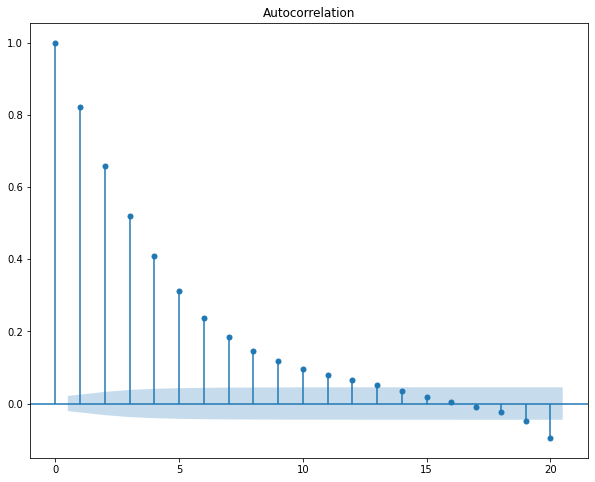

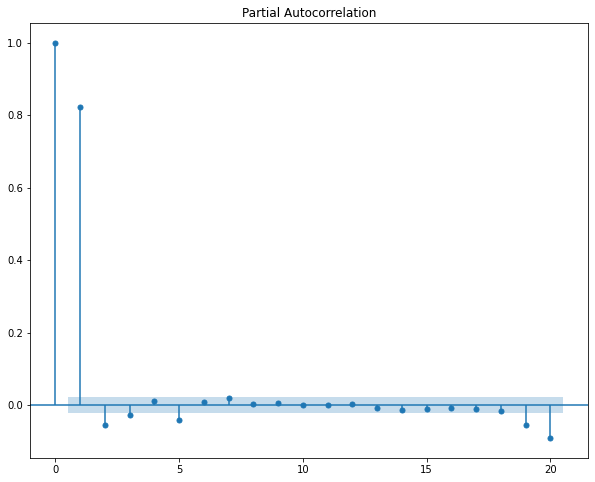

In [57]:
plot_acf(test['first_difference'], lags=20)
plt.show()

plot_pacf(test['first_difference'], lags=20)
plt.show()

# PACF has a peak at lag 1, so it suggests at least 1 AR(1) process, and along with ACF no MA process
# and seasonality terms (P,D,Q)
# Although these plots can give us a general idea of the processes,
# it's nice to choose a model that yield the lowest BIC and AIC (what does autoarima tells us?)

# Granger Causality Test

In [58]:
grangercausalitytests(test[['local_gen_first_difference', 'first_difference']].dropna(), maxlag=5)

# p-val < 0.05 = 0. so Knowing the Local Generation Values is usefull for Energy Consumption prediction.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=62.6134 , p=0.0000  , df_denom=8708, df_num=1
ssr based chi2 test:   chi2=62.6350 , p=0.0000  , df=1
likelihood ratio test: chi2=62.4109 , p=0.0000  , df=1
parameter F test:         F=62.6134 , p=0.0000  , df_denom=8708, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=36.4923 , p=0.0000  , df_denom=8705, df_num=2
ssr based chi2 test:   chi2=73.0264 , p=0.0000  , df=2
likelihood ratio test: chi2=72.7220 , p=0.0000  , df=2
parameter F test:         F=36.4923 , p=0.0000  , df_denom=8705, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=24.6813 , p=0.0000  , df_denom=8702, df_num=3
ssr based chi2 test:   chi2=74.1034 , p=0.0000  , df=3
likelihood ratio test: chi2=73.7899 , p=0.0000  , df=3
parameter F test:         F=24.6813 , p=0.0000  , df_denom=8702, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=18.5846 , p=0.

{1: ({'ssr_ftest': (62.61341127300984, 2.8235194084182403e-15, 8708.0, 1),
   'ssr_chi2test': (62.634982269084595, 2.487948519551106e-15, 1),
   'lrtest': (62.41087274965321, 2.7877985818443756e-15, 1),
   'params_ftest': (62.61341127303746, 2.8235194083789385e-15, 8708.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (36.49225671572702, 1.6507576084409447e-16, 8705.0, 2),
   'ssr_chi2test': (73.02643446156974, 1.3883892428772598e-16, 2),
   'lrtest': (72.72200056644942, 1.6166582412665824e-16, 2),
   'params_ftest': (36.49225671571854, 1.6507576084560168e-16, 8705.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (24.68128399195192, 6.764447335856207e-16, 8702.0, 3),
   'ssr_chi2test': (74.1034137965672, 5.63967014920836e-16, 3),
   'lrtest': (73.78992409677448, 6.583100639245887e-16, 3),
   'params_ftest': (24.681283991948288, 6.764447335891822e-16, 8702.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0.,

In [59]:
data = new_df[['Interface','Local Generation']]

In [60]:
data.head()

,Interface,Local Generation
DATA,,
2021-01-01 00:00:00,19.753853,0.0
2021-01-01 01:00:00,18.472114,0.0
2021-01-01 02:00:00,17.617622,0.0
2021-01-01 03:00:00,16.599771,0.0
2021-01-01 04:00:00,16.298185,0.0


# Train Test Split

In [61]:
train_df = new_df.loc[(new_df.index >= datetime(2021, 1, 1)) & (new_df.index < datetime(2021, 12, 1))][['Interface', 'Local Generation']]
test_df = new_df.loc[(new_df.index >= datetime(2021, 12, 28)) & (new_df.index < datetime(2021, 12, 31))][['Interface', 'Local Generation']]
exogenous_feature_values = list(new_df.loc[(new_df.index >= datetime(2021, 12, 28)) & (new_df.index < datetime(2021, 12, 31))][['Local Generation']].values)

In [62]:
print(train_df.shape, test_df.shape)

(8016, 2) (72, 2)


# Part 1 - Fit Autoarima and Get Residuals

In [63]:
sarima_model_fitted = pmdarima.auto_arima(new_df[['Interface']],
                                         exogenous=new_df[['Local Generation']],
                                         seasonal=True)

p, d, q = sarima_model_fitted.order
sarima_residuals = sarima_model_fitted.arima_res_.resid

In [64]:
sarima_model_fitted

ARIMA(order=(5, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [65]:
sarima_model_fitted.summary()

# Ljung-Box p-val 0.79 > 0.05 - residuals are not auto-correlated
# reject homoskedasticity - the residual series it is not a white noise

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 8736
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -17880.550
Date:                Mon, 20 Jun 2022   AIC                          35779.100
Time:                        12:42:26   BIC                          35842.775
Sample:                    01-01-2021   HQIC                         35800.799
                         - 12-30-2021                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Local Generation    -1.1805      0.008   -148.802      0.000      -1.196      -1.165
ar.L1                1.8803      0.022     84.482      0.000       1.837       1.924
ar.L2               -0.9790      0.025    -39.524      0.000      -1.028      -0.930
ar.L3               -0.0351      0.012     -2.972      0.003      -0.058      -0.012
ar.L4                0.1075      0.012      8.672      0.000       0.083       0.132
ar.L5               -0.0334      0.008     -3.953      0.000      -0.050      -0.017
ma.L1               -1.8041      0.021    -83.915      0.000      -1.846      -1.762
ma.L2                0.8139      0.021     39.248      0.000       0.773       0.855
sigma2               3.5123      0.023    149.800      0.000       3.466       3.558
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):             51788.58
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               4.84   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

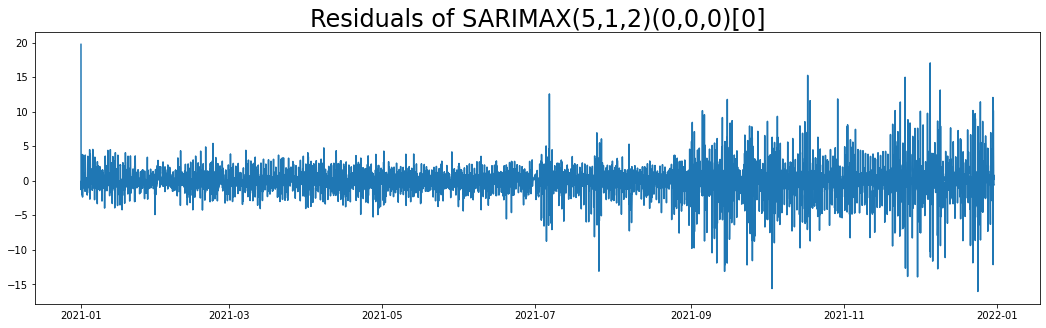

In [66]:
plt.rcParams["figure.figsize"] = 18, 5
plt.plot(sarima_residuals, label = "Residuals")
plt.title("Residuals of SARIMAX(5,1,2)(0,0,0)[0]", size = 24)
plt.savefig(f'{SAVE_DIR}/sarimax_residuals.png')
plt.show()

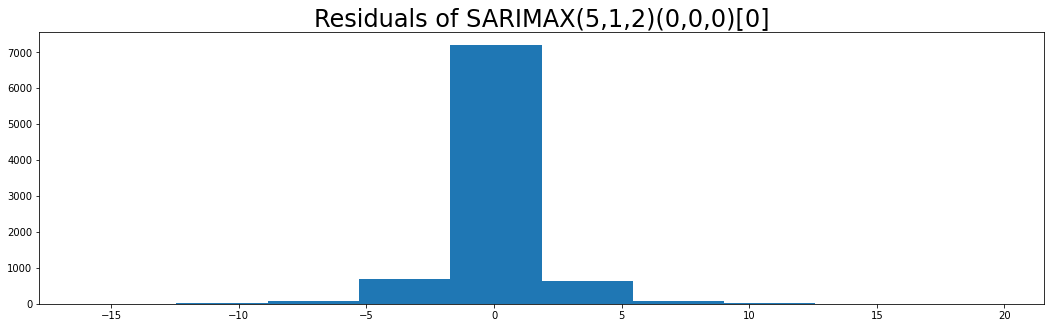

In [67]:
plt.rcParams["figure.figsize"] = 18, 5
plt.hist(sarima_residuals, label = "Residuals")
plt.title("Residuals of SARIMAX(5,1,2)(0,0,0)[0]", size = 24)
plt.show()

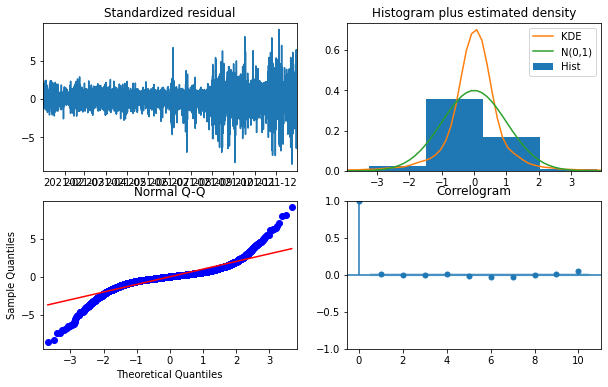

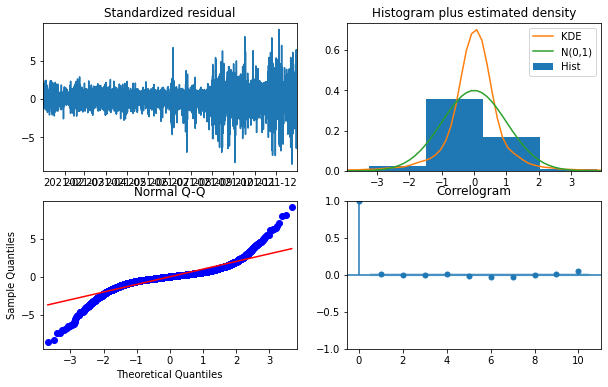

In [68]:
sarima_model_fitted.plot_diagnostics(figsize=(10,6))

In [69]:
# Skewness in the residuals distribution
# Volatility Clusters in the residuals series
# Heteroskedacity in the residuals series

# This said, the model predictions may not be reliable. Thus we need to inspect volatility (Fit a Garch model).

# Forecast Interface - Cross Validation

In [70]:
ar_preds = []
history = [x for x in train_df['Interface'].values]
ex_history = [x for x in train_df[['Local Generation']].values]

for t in range(len(test_df['Interface'].values)):
    model = SARIMAX(history, 
        order=(5,1,2),
        seasonal_order=(0,0,0,0),
        exogenous=ex_history)
    
    model_fit = model.fit()
    output = model_fit.forecast()
    ar_preds.append(output[0])
    history.append(test_df['Interface'].values[t])
    ex_history.append(exogenous_feature_values[t])

ar_pred_series = pd.Series(ar_preds, index=test_df.index)

C:\Users\dgalves\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dgalves\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dgalves\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dgalves\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dgalves\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarni

C:\Users\dgalves\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dgalves\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dgalves\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dgalves\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dgalves\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarni

# Forecast Without Cross Validation

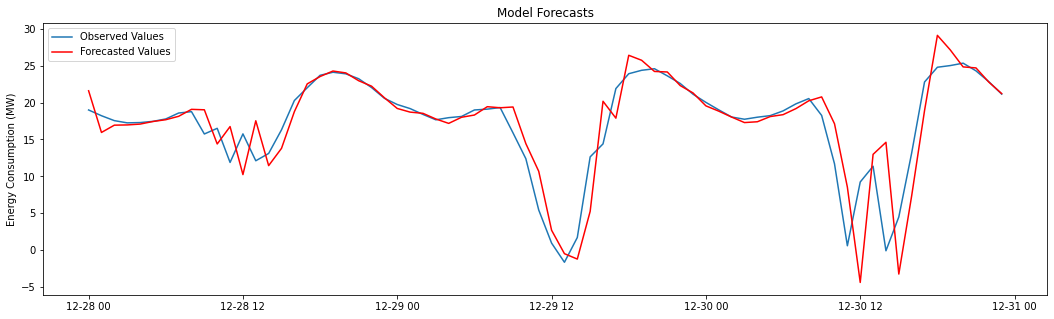

In [71]:
plt.plot(test_df['Interface'], label='Observed Values')
plt.plot(ar_pred_series, color='red', label='Forecasted Values')
plt.legend()
plt.title('Model Forecasts')
plt.ylabel('Energy Consumption (MW)')
plt.show()

In [72]:
sarimax_model = SARIMAX(history, 
        order=(5,1,2),
        seasonal_order=(0,0,0,0),
        exogenous=ex_history)
    
sarimax_model_fit = sarimax_model.fit()
predictions = sarimax_model_fit.predict(start =len(train_df), end=len(train_df)+len(test_df),exog=test_df['Local Generation'])

C:\Users\dgalves\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


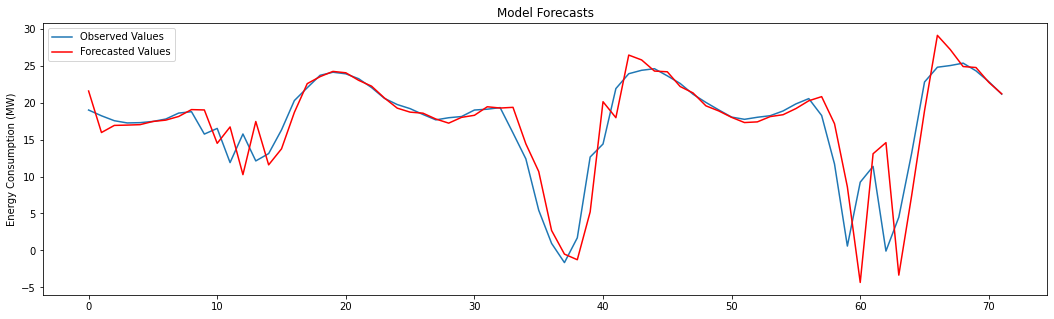

In [73]:
plt.plot(test_df['Interface'].values, label='Observed Values')
plt.plot(predictions[:len(test_df)], color='red', label='Forecasted Values')
plt.legend()
plt.title('Model Forecasts')
plt.ylabel('Energy Consumption (MW)')
plt.savefig(f'{SAVE_DIR}/sarimax_forecast.png')
plt.show()

In [74]:
rmse = np.sqrt(np.mean(predictions[:len(test_df)] - test_df['Interface'])**2)
rmse

0.15569550719732117

In [75]:
MAPE = np.mean(np.abs((test_df['Interface'].values - predictions[:len(test_df)]) / test_df['Interface'].values)) * 100
MAPE

270.7650169499486

# Let's Inspect Volatility

In [76]:
from statsmodels.stats.diagnostic import het_arch

arch_test = het_arch(sarima_residuals, maxlag=50)

print(f'Lagrange multiplier p-value: {arch_test[1]}')
print(f'F test p-value: {arch_test[3]}')

# p-val = 0 -> presence of heteroskedasticity in the residuals

Lagrange multiplier p-value: 0.0
F test p-value: 0.0


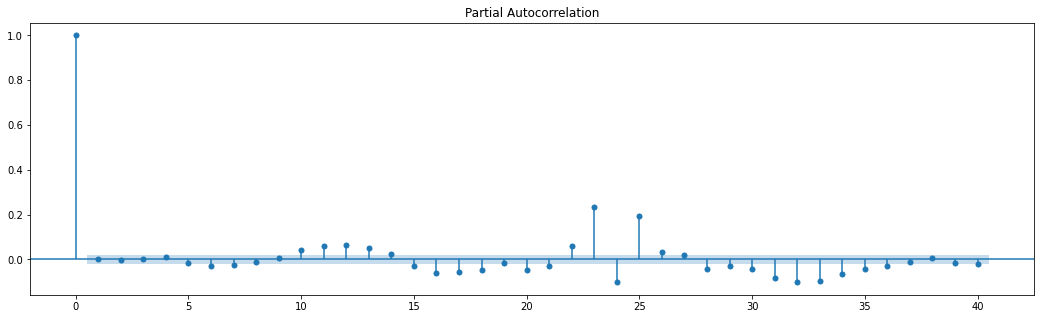

In [77]:
plot_pacf(sarima_residuals)
plt.show()

# Fit Garch Model on Residuals

In [78]:
import arch

garch = arch.arch_model(sarima_residuals, vol='EGARCH', p=1, q=1)
garch_fitted = garch.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 16850.001978427572
Iteration:      2,   Func. Count:     16,   Neg. LLF: 16666.80701852164
Iteration:      3,   Func. Count:     26,   Neg. LLF: 16650.006196276892
Iteration:      4,   Func. Count:     35,   Neg. LLF: 16523.948313466015
Iteration:      5,   Func. Count:     42,   Neg. LLF: 16340.859204194401
Iteration:      6,   Func. Count:     50,   Neg. LLF: 16251.81760296339
Iteration:      7,   Func. Count:     56,   Neg. LLF: 16150.381919220928
Iteration:      8,   Func. Count:     62,   Neg. LLF: 16114.503395907897
Iteration:      9,   Func. Count:     68,   Neg. LLF: 16103.052497222805
Iteration:     10,   Func. Count:     74,   Neg. LLF: 16101.368562578238
Iteration:     11,   Func. Count:     80,   Neg. LLF: 16101.227354908959
Iteration:     12,   Func. Count:     86,   Neg. LLF: 16101.215917645844
Iteration:     13,   Func. Count:     92,   Neg. LLF: 16101.21474631409
Iteration:     14,   Func. Count:     99,   Neg. LLF: 

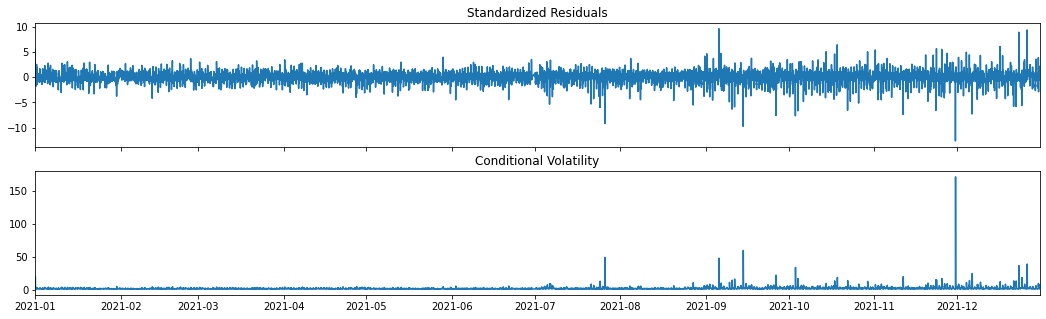

In [79]:
garch_fitted.plot()
plt.savefig(f'{SAVE_DIR}/garch_volatility.png')
plt.show()

In [80]:
new_df['first_difference'] = new_df['Interface'] - new_df['Interface'].shift()

[]

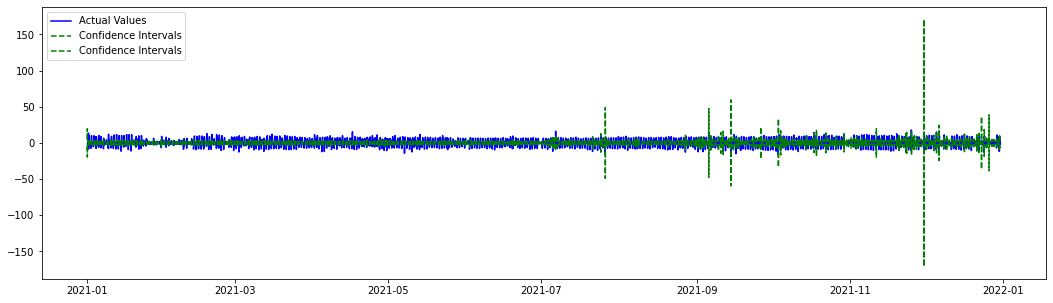

In [81]:
plt.rcParams["figure.figsize"] = 18, 5
plt.plot(new_df['first_difference'], color = "blue", label = "Actual Values")
plt.plot(garch_fitted.conditional_volatility,color = "green", linestyle = "--", label = "Confidence Intervals")
plt.plot(-garch_fitted.conditional_volatility,color = "green", linestyle = "--", label = "Confidence Intervals")
plt.legend()
plt.savefig(f'{SAVE_DIR}/garch_and_series.png')
plt.plot()

# Part 2 - Recurrent Neural Networks Fit

# Train Test Split

In [82]:
BEGIN_TRAIN_DATE = datetime(2021, 1, 1)
END_TRAIN_DATE = datetime(2021, 12, 1)
BEGIN_TEST_DATE = datetime(2021, 12, 1)
END_TEST_DATE = datetime(2021, 12, 14)
BEGIN_FORECAST_DATE = datetime(2021, 12, 14)
END_FORECAST_DATE = datetime(2021, 12, 31)

train_df = new_df.loc[(new_df.index >= BEGIN_TRAIN_DATE) & (new_df.index < END_TRAIN_DATE)][['Interface', 'Local Generation', 'is_workday', 'season_of_year']]
train_series_data = new_df.loc[(new_df.index >= BEGIN_TRAIN_DATE) & (new_df.index < END_TRAIN_DATE)][['Interface', 'Local Generation']]

test_df = new_df.loc[(new_df.index >= BEGIN_TEST_DATE) & (new_df.index < END_TEST_DATE)][['Interface', 'Local Generation', 'is_workday', 'season_of_year']]
test_series_data = new_df.loc[(new_df.index >= BEGIN_TEST_DATE) & (new_df.index < END_TEST_DATE)][['Interface', 'Local Generation']]

plot_df = new_df.loc[(new_df.index >= BEGIN_TEST_DATE) & (new_df.index < END_TEST_DATE)][['Interface']]

forecast_data = new_df.loc[(new_df.index >= BEGIN_FORECAST_DATE) & (new_df.index < END_FORECAST_DATE)][['Interface', 'Local Generation', 'is_workday', 'season_of_year']]



In [83]:
garch_pred_volatility = np.array([garch_fitted.conditional_volatility]).reshape(-1,1)
train_volatility_garch = garch_pred_volatility[0: len(train_df), :]
test_volatility_garch = garch_pred_volatility[len(train_df):len(train_df)+len(test_df), :]
forecast_volatility_garch = garch_pred_volatility[len(train_df)+len(test_df):len(train_df)+len(test_df)+len(forecast_data), :]

print(train_volatility_garch.shape, test_volatility_garch.shape, forecast_volatility_garch.shape)


(8016, 1) (312, 1) (408, 1)


In [84]:
# Append 'is workday' and 'season_of_year' to volatility data - [volatility, is_workday, seaso_of_year]
train_volatility_garch = np.column_stack((train_volatility_garch,train_df['is_workday'].values,train_df['season_of_year'].values))
test_volatility_garch = np.column_stack((test_volatility_garch, test_df['is_workday'].values,test_df['season_of_year'].values))
forecast_volatility_garch = np.column_stack((forecast_volatility_garch, forecast_data['is_workday'].values, forecast_data['season_of_year'].values))


# Scale Data

In [85]:
scaler_1 = MinMaxScaler(feature_range=(0,1))
scaler_1.fit(train_volatility_garch)

garch_train_scaled_data = scaler_1.transform(train_volatility_garch)
garch_test_scaled_data = scaler_1.transform(test_volatility_garch)
garch_forecast_scaled_data = scaler_1.transform(forecast_volatility_garch)

In [86]:
scaler_2 = MinMaxScaler(feature_range=(0,1))
scaler_2.fit(train_df)

train_scaled_data = scaler_2.transform(train_df)
test_scaled_data = scaler_2.transform(test_df)
forecast_scaled_data = scaler_2.transform(forecast_data)

In [87]:
scaler_3 = MinMaxScaler(feature_range=(0,1))
scaler_3.fit(train_series_data)

train_series_scaled_data = scaler_3.transform(train_series_data)
test_series_scaled_data = scaler_3.transform(test_series_data)
forecast_series_scaled_data = scaler_3.transform(forecast_data[['Interface','Local Generation']].values)

# Create Sequences

In [88]:
def create_sequences(scaled_data, offset=168):
    # offset = Last 168 hours -> 7 days sequences
    
    num_features = scaled_data.shape[1]
    x = []
    y = []
    
    for i in range(offset, len(scaled_data)):
        x.append(scaled_data[i-offset:i,0:num_features])
        y.append(scaled_data[i,0])

    x = np.array(x)
    y = np.array(y).reshape(-1,1)
    
    return x, y

In [89]:
x_train, y_train = create_sequences(train_scaled_data)
x_test, y_test = create_sequences(test_scaled_data)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(7848, 168, 4) (144, 168, 4)
(7848, 1) (144, 1)


In [90]:
x_train_garch, _ = create_sequences(garch_train_scaled_data)
x_test_garch, _ = create_sequences(garch_test_scaled_data)

print(x_train_garch.shape, x_test_garch.shape)

(7848, 168, 3) (144, 168, 3)


In [91]:
x_train_series, _ = create_sequences(train_series_scaled_data)
x_test_series, _ = create_sequences(test_series_scaled_data)

print(x_train_series.shape, x_test_series.shape)

(7848, 168, 2) (144, 168, 2)


In [92]:
forecast_volatility, _ = create_sequences(garch_forecast_scaled_data)
forecast_data_, _ = create_sequences(forecast_scaled_data)
forecast_series_data, _ = create_sequences(forecast_series_scaled_data)

print(forecast_volatility.shape, forecast_data_.shape, forecast_series_data.shape)

(240, 168, 3) (240, 168, 4) (240, 168, 2)


In [93]:
# All Set and Ready to go!!

# Simple LSTM

In [94]:
model_1_input = Input(shape=(x_train.shape[1], x_train.shape[2]))

lstm_layer_1 = LSTM(100, return_sequences=True, dropout=0.2)(model_1_input)
lstm_layer_2 = LSTM(100, return_sequences=True, dropout=0.2)(lstm_layer_1)
lstm_layer_3 = LSTM(100, return_sequences=True, dropout=0.2)(lstm_layer_2)
lstm_layer_4 = LSTM(100, return_sequences=True, dropout=0.2)(lstm_layer_3)
lstm_layer_5 = LSTM(100, return_sequences=True, dropout=0.2)(lstm_layer_4)
lstm_layer_6 = LSTM(100, dropout=0.2)(lstm_layer_5)

dense_1 = Dense(512, activation='relu')(lstm_layer_6)
dpout_1 = Dropout(0.2)(dense_1)
dense_2 = Dense(256, activation='relu')(dpout_1)
dpout_2 = Dropout(0.2)(dense_2)

output_layer = Dense(1, activation='linear')(dpout_2)

model_lstm = Model(inputs=model_1_input, outputs=output_layer)

In [95]:
model_lstm.compile(optimizer=SGD(momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mse'])

In [96]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", 
                                        patience = 10,
                                        restore_best_weights = True)

In [ ]:
hist = model_lstm.fit(x_train, y_train,
            batch_size = 32,
            epochs = 100,
            callbacks=[earlystopping],
            validation_data=(x_test, y_test))

Epoch 1/100
246/246 [==============================] - 166s 647ms/step - loss: 0.0301 - mse: 0.0602 - val_loss: 0.0178 - val_mse: 0.0356
Epoch 2/100
246/246 [==============================] - 164s 666ms/step - loss: 0.0244 - mse: 0.0489 - val_loss: 0.0173 - val_mse: 0.0347
Epoch 3/100
246/246 [==============================] - 159s 646ms/step - loss: 0.0243 - mse: 0.0486 - val_loss: 0.0169 - val_mse: 0.0339
Epoch 4/100
246/246 [==============================] - 161s 654ms/step - loss: 0.0239 - mse: 0.0478 - val_loss: 0.0167 - val_mse: 0.0335
Epoch 5/100
246/246 [==============================] - 160s 651ms/step - loss: 0.0233 - mse: 0.0466 - val_loss: 0.0167 - val_mse: 0.0334
Epoch 6/100
246/246 [==============================] - 160s 649ms/step - loss: 0.0226 - mse: 0.0452 - val_loss: 0.0168 - val_mse: 0.0335
Epoch 7/100
246/246 [==============================] - 160s 649ms/step - loss: 0.0208 - mse: 0.0417 - val_loss: 0.0176 - val_mse: 0.0352
Epoch 8/100
246/246 [====================

In [ ]:
y_pred = model_lstm.predict(x_test)

In [ ]:
y_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler.fit(train_df['Interface'].values.reshape(-1,1))

In [ ]:
rmse = np.sqrt(np.mean(y_pred - y_test)**2)
rmse

In [ ]:
y_pred = y_scaler.inverse_transform(y_pred)

In [ ]:
# Plot the data
interface_data = plot_df.filter(['Interface'])
valid = interface_data[-x_test.shape[0]:]
valid['Predictions'] = y_pred

plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Interface (Mw)', fontsize=18)
plt.plot(valid[['Interface', 'Predictions']])
plt.legend(['Validation', 'Predictions'], loc='lower right')
plt.savefig(f'{SAVE_DIR}/lstm_forecast.png')
plt.show()

In [ ]:
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.title('mse')
plt.savefig(f'{SAVE_DIR}/lstm_mse.png')
plt.show()

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.savefig(f'{SAVE_DIR}/lstm_loss.png')
plt.show()

In [ ]:
rmse = np.sqrt(np.mean(valid['Predictions'] - valid['Interface'])**2)
rmse

In [ ]:
MAPE = np.mean(np.abs((valid['Interface'] - valid['Predictions']) / valid['Interface'])) * 100
MAPE

# Bidirecional LSTM

In [ ]:
model_1_input = Input(shape=(x_train.shape[1], x_train.shape[2]))

lstm_layer_1 = LSTM(100, return_sequences=True, dropout=0.2)(model_1_input)
lstm_layer_2 = LSTM(100, return_sequences=True, dropout=0.2)(lstm_layer_1)

bidirectional_layer_1 = Bidirectional(LSTM(100, dropout=0.2, return_sequences=True, recurrent_dropout=0))(lstm_layer_2)
bidirectional_layer_2 = Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0))(bidirectional_layer_1)

dense_1 = Dense(512, activation='relu')(bidirectional_layer_2)
dpout_1 = Dropout(0.2)(dense_1)
dense_2 = Dense(256, activation='relu')(dpout_1)
dpout_2 = Dropout(0.2)(dense_2)

output_layer = Dense(1, activation='linear')(dpout_2)

model_bi_lstm = Model(inputs=model_1_input, outputs=output_layer)

In [ ]:
model_bi_lstm.compile(optimizer=SGD(momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mse'])

In [ ]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", 
                                        patience = 10, 
                                        restore_best_weights = True)

In [ ]:
hist = model_bi_lstm.fit(x_train, y_train,
        batch_size = 32, 
        epochs = 100,
        callbacks=[earlystopping],
        validation_data=(x_test, y_test))

In [ ]:
y_pred = model_bi_lstm.predict(x_test)

In [ ]:
rmse = np.sqrt(np.mean(y_pred - y_test)**2)
rmse

In [ ]:
y_pred = y_scaler.inverse_transform(y_pred)

In [ ]:
# Plot the data
interface_data = plot_df.filter(['Interface'])
valid = interface_data[-x_test.shape[0]:]
valid['Predictions'] = y_pred

plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Interface (Mw)', fontsize=18)
plt.plot(valid[['Interface', 'Predictions']])
plt.legend(['Validation', 'Predictions'], loc='lower right')
plt.savefig(f'{SAVE_DIR}/bi_lstm_forecast.png')
plt.show()

In [ ]:
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.title('mse')
plt.savefig(f'{SAVE_DIR}/bi_lstm_mse.png')
plt.show()

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.savefig(f'{SAVE_DIR}/bi_lstm_loss.png')
plt.show()

In [ ]:
rmse = np.sqrt(np.mean(valid['Predictions'] - valid['Interface'])**2)
rmse

In [ ]:
MAPE = np.mean(np.abs((valid['Interface'] - valid['Predictions']) / valid['Interface'])) * 100
MAPE

# Part 3 - Stack Convolutional Network + LSTM for Series Prediction + LSTM for Volatility Prediction

In [ ]:
# First Model - Bidirectional LSTM for Time Series Forecasting
series_input = Input(shape=(x_train.shape[1], x_train.shape[2]))

bidirectional_layer_1 = Bidirectional(LSTM(100, dropout=0.2, return_sequences=True, recurrent_dropout=0))(series_input)
bidirectional_layer_2 = Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0))(bidirectional_layer_1)

dense_1 = Dense(256, activation='relu')(bidirectional_layer_2)
dpout_1 = Dropout(0.2)(dense_1)

forecast_layer = Dense(1, activation='linear')(dpout_1)

# Second Model - Bidirectional LSTM for Volatility Forecasting
volatility_input = Input(shape=(x_train_garch.shape[1], x_train_garch.shape[2]))

bidirectional_layer_3 = Bidirectional(LSTM(100, dropout=0.2,return_sequences=True, recurrent_dropout=0))(volatility_input)
bidirectional_layer_4 = Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0))(bidirectional_layer_3)

dense_3 = Dense(256, activation='relu')(bidirectional_layer_4)
dpout_3 = Dropout(0.2)(dense_3)
volatility_layer = Dense(1, activation='linear')(dpout_3)

# Third Model - 1D CNN for Time Series Feature Extraction
cnn_input = Input(shape=(x_train_series.shape[1], x_train_series.shape[2]))

conv_layer_1 = Conv1D(filters=64, 
                    kernel_size=3,
                    strides=1, 
                    padding="causal", 
                    activation='relu')(cnn_input)

pooling_layer_1 = MaxPooling1D(pool_size=2)(conv_layer_1)
dpout_pooling_1 = Dropout(0.2)(pooling_layer_1)

conv_layer_2 = Conv1D(filters=128, 
                    kernel_size=3,
                    strides=1,
                    padding="causal", 
                    activation='relu')(dpout_pooling_1)

pooling_layer_2 = MaxPooling1D(pool_size=2)(conv_layer_2)
dpout_pooling_2 = Dropout(0.2)(pooling_layer_2)

flatten_layer = Flatten()(dpout_pooling_2)

dense_5 = Dense(128, activation='relu')(flatten_layer)
dpout_5 = Dropout(0.2)(dense_5)
dense_6 = Dense(128, activation='relu')(dpout_5)
dpout_6 = Dropout(0.2)(dense_6)

series_cnn_features = Dense(1, activation='linear')(dpout_6)

# Sum forecast and volatility
sum_forecast_and_volatility = Add()([forecast_layer, volatility_layer])

# Append Forecast+Volatility to CNN Extracted Features
concat_layer = concatenate([sum_forecast_and_volatility, series_cnn_features])

# Final Fully Connected Layer - concat_layer Interpretation
dense_final = Dense(128, activation='relu')(concat_layer)
dpout_6 = Dropout(0.2)(dense_final)

# Final Output Probability
output_layer = Dense(1, activation='linear')(dpout_6)

model = Model(inputs=[series_input, volatility_input, cnn_input], outputs=output_layer)


In [ ]:
model.compile(optimizer=SGD(momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mse'])
#model.compile(optimizer=Adam(), loss=tf.keras.losses.Huber(), metrics=['mse'])

In [ ]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", 
                                        patience = 10, 
                                        restore_best_weights = True)

In [ ]:
hist = model.fit([x_train, x_train_garch, x_train_series], y_train,
        batch_size = 32,
        epochs = 200,
        callbacks=[earlystopping],
        validation_data=([x_test, x_test_garch, x_test_series], y_test))

In [ ]:
y_pred = model.predict([x_test, x_test_garch, x_test_series])

In [ ]:
rmse = np.sqrt(np.mean(y_pred - y_test)**2)
rmse

In [ ]:
y_pred = y_scaler.inverse_transform(y_pred)

In [ ]:
interface_data = plot_df.filter(['Interface'])
valid = interface_data[-x_test.shape[0]:]
valid['Predictions'] = y_pred

plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Interface (Mw)', fontsize=18)
plt.plot(valid[['Interface', 'Predictions']])
plt.legend(['Validation', 'Predictions'], loc='lower right')
plt.savefig(f'{SAVE_DIR}/model_forecast.png')
plt.show()

In [ ]:
rmse = np.sqrt(np.mean(valid['Predictions'] - valid['Interface'])**2)
rmse

In [ ]:
MAPE = np.mean(np.abs((valid['Interface'] - valid['Predictions']) / valid['Interface'])) * 100
MAPE

In [ ]:
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.title('mse')
plt.savefig(f'{SAVE_DIR}/model_mse.png')
plt.show()

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.savefig(f'{SAVE_DIR}/model_loss.png')
plt.show()

# Forecast

In [ ]:
FUTURE = 167 # Amount of hours to predict
output = []
x_forecast = np.reshape(forecast_data_[0],(1, forecast_data_[0].shape[0], forecast_data_[0].shape[1]))
series_forecast = np.reshape(forecast_series_data[0],(1, forecast_series_data[0].shape[0], forecast_series_data[0].shape[1]))

for i in range(FUTURE):
    volatility_forecast = np.reshape(forecast_volatility[i],(1, forecast_volatility[i].shape[0], forecast_volatility[i].shape[1]))
    
    y_forecast = model.predict([x_forecast, volatility_forecast, series_forecast])[0][0]
    
    # Eliminate 'Interface' data from next sequence and append predicted value instead
    # example:
    # [interface, local generation, is_workday, season_of_year] -> [local generation, is_workday, season_of_year]
    # [local generation, is_workday, season_of_year] -> [interface prediction, local generation, is_workday, season_of_year]
    pred_data = np.append(y_forecast, forecast_data_[0][i,-3:])
    pred_series = np.append(y_forecast, forecast_series_data[0][i, 1])
    
    # Append the last sequence to the next sequence and eliminate the older
    # example:
    # [1,2,3] - p1
    # [2,3, p1] - p2
    # [3, p1, p2] - p3
    x_forecast = np.vstack((forecast_data_[i,:][1:], pred_data))
    series_forecast = np.vstack((forecast_series_data[i,:][1:], pred_series))
    
    # Reshape to get a (BATCH_SIZE, 168 , NUMBER_OF_FEATURES) -> LSTM input shape
    x_forecast = np.reshape(x_forecast,(1, x_forecast.shape[0], x_forecast.shape[1]))
    series_forecast = np.reshape(series_forecast,(1, series_forecast.shape[0], series_forecast.shape[1]))
    
    output.append(y_forecast) 
    

In [ ]:
forecast_prediction = y_scaler.inverse_transform(np.array(output).reshape(-1,1))

In [ ]:
plt.plot(forecast_prediction, color='red')
plt.plot(forecast_data['Interface'].values[:FUTURE])
plt.savefig(f'{SAVE_DIR}/model_final_forecast.png')
plt.title('Model Forecast', fontsize=18)
plt.xlabel('Hour', fontsize=18)
plt.ylabel('Interface (Mw)', fontsize=18)
plt.legend(['Predictions', 'Real Values'], loc='lower right')
plt.show()

In [ ]:
rmse = np.sqrt(np.mean(forecast_prediction - forecast_data['Interface'].values[:FUTURE])**2)
rmse

In [ ]:
MAPE = np.mean(np.abs((forecast_data['Interface'].values[:FUTURE] - forecast_prediction) / forecast_data['Interface'].values[:FUTURE])) * 100
MAPE